# Import and Setup

In [5]:
import pandas as pd
import numpy as np
import json
import os
import re
from tqdm import tqdm
import pickle
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
sns.set_theme(style='whitegrid')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.svm import OneClassSVM
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from imblearn.over_sampling import RandomOverSampler

from sentence_transformers import SentenceTransformer

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import tensorflow_hub as hub

# Load the Universal Sentence Encoder module
module_url = 'https://tfhub.dev/google/universal-sentence-encoder-large/5'
embed = hub.load(module_url)

import torch
from scipy.spatial.distance import cosine
from transformers import AutoModel, AutoTokenizer

# Import our models. The package will take care of downloading the models automatically
tokenizer = AutoTokenizer.from_pretrained("princeton-nlp/sup-simcse-roberta-large")
model_embedding = AutoModel.from_pretrained("princeton-nlp/sup-simcse-roberta-large")

def get_embeddings(texts,batch_size=20):
    # Tokenize input texts
    list_embedding = []
    texts = [t for t in texts if t]
    num_batch = len(texts)//batch_size
    for i in tqdm(range(num_batch+1)):
        inputs = tokenizer(texts[i*batch_size:(i+1)*batch_size], padding=True, truncation=True, return_tensors="pt",max_length=300)
        # Get the embeddings
        with torch.no_grad():
            embeddings = model_embedding(**inputs, output_hidden_states=True, return_dict=True).pooler_output
            list_embedding.append(embeddings)
    return torch.cat(list_embedding).cpu()
# embed = get_embeddings

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jirayuwat/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
TRAIN_PATH = r"train_for_student.json"
TEST_PATH = r"test_for_student.json"

TRAIN_PATH = os.path.join(os.path.pardir, "data", TRAIN_PATH)
TEST_PATH = os.path.join(os.path.pardir, "data", TEST_PATH)

LABEL_LIST = ['CE','ENV','BME','PE','METAL','ME','EE','CPE','OPTIC','NANO','CHE','MATENG','AGRI','EDU','IE','SAFETY','MATH','MATSCI']

# Preprocess

In [7]:
def clean_and_tokenize(df, is_test=False):
    df = df.copy()

    df['Text'] = df['Title'] + " " + df['Abstract']

    df.drop(columns=['Title', 'Abstract'], inplace=True)

    # lower case
    # df['Text'] = df['Text'].apply(lambda x: x.lower())

    # remove special characters
    df['Text'] = df['Text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', ' ', x))

    # remove text
    target_text = ['published', 'licence', 'iop', 'publishing', 'ltd', 'using', 'ieee', 'association', 'elsevier', 'springer', 'wal', 'system', 'thailand', 'john' ,'wiley', 'sons', 'international', 'publications']
    df['Text'] = df['Text'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in target_text]))

    # lemmitize
    # tokenize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    df['Text'] = df['Text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in word_tokenize(x)  if lemmatizer.lemmatize(word).lower() not in stop_words])
    
    # show random text 5
    if not is_test:
        for i in range(5):
            idx = np.random.randint(0, len(df))
            print(f"Cleaned: {' '.join(df['Text'].iloc[idx])}\n")

    # word cloud
    all_words = [word for tokens in df['Text'] for word in tokens]
    wc = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(' '.join(all_words))
    plt.figure(figsize=(10, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.title('Top words after clean and tokenize')
    plt.axis('off')
    plt.show()

    return df

def sentences_2_vec(df):
    df = df.copy()

    eb = embed(df['Text'].apply(lambda x: ' '.join(x)))
    df['Text'] = eb.numpy().tolist()

    return df

def get_data(X, y, label, test_size=0.1, random_state=42, umsampling = True):
    X = np.array([np.array(x) for x in X['Text']])
    y = y.copy()[label]

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

    # oversampling
    if umsampling:
        ros = RandomOverSampler(random_state=random_state)
        X_train, y_train = ros.fit_resample(X_train, y_train)

    return X_train, X_val, y_train, y_val

def load_data(path, has_label=True, vectorize=True):
    # load df
    data = json.load(open(path))

    # make df
    df = pd.DataFrame(data).transpose()

    # create labels
    if has_label:
        for idx, label in enumerate(LABEL_LIST):
            df[label] = df['Classes'].apply(lambda x: 1 if label in x else 0)
        df.drop(columns=['Classes'], inplace=True)

    # create X, y
    df = clean_and_tokenize(df, not has_label)
    if has_label:
        X = df.drop(columns=LABEL_LIST)
        if vectorize:
            X = sentences_2_vec(X)
        y = df[LABEL_LIST]
        return X, y
    else:
        if vectorize:
            df = sentences_2_vec(df)
        return np.array([np.array(x) for x in df['Text']])


Cleaned: Log End Cut Area Detection Images Taken Rear End Eucalyptus Timber Trucks visual estimation log volume size distribution eucalyptus log truck challenging task inspector paper mill typically perform task information used determine whether log pas criterion mill find appropriate price method far accurate efficient paper present new approach automatically detects eucalyptus logend cut area rear end image eucalyptus timber truck method used machine learning image processing technique consists three part timber truck detection log segmentation log counting proposed wa tested image timber truck dataset achieved average accuracy log segmentation false negative

Cleaned: Simple effective technology sustainable biodiesel production high power household fruit blender commercial household fruit blender proposed simple le time consuming effective biodiesel production technique research work Biodiesel wa successfully produced W commercial household fruit blender Due synergistic effect deri

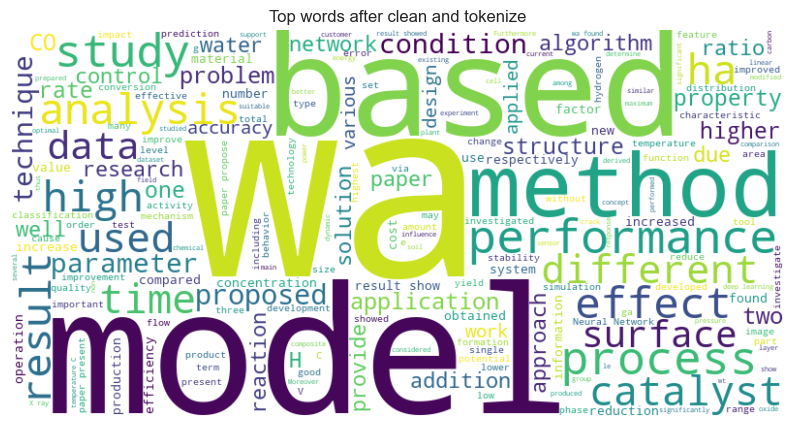

In [8]:
X_embedded, y = load_data(TRAIN_PATH, vectorize=True)

# Model

In [10]:
model_by_label = {}
avg_f1 = 0
for label in LABEL_LIST:
    # get data
    # X_train, X_val, y_train, y_val = get_data(X_embedded, y, label, umsampling = False)
    X_train = np.array([np.array(x) for x in X_embedded.copy()['Text']])
    y_train = y.copy()[label]


    model = VotingClassifier(estimators=[('svc', SVC(class_weight='balanced', kernel='linear')),
                                         ('logistic', LogisticRegression(class_weight='balanced')),
                                         ('guassiannb', GaussianNB())],
                                voting='hard').fit(X_train, y_train)

    # evaluate
    f1 = np.mean(sorted(cross_val_score(model, X_train, y_train, cv=5, scoring='f1'))[1:-1])
    avg_f1 += f1
    print(f"Label: {label}")
    print(f"\tData shape: {X_train.shape}")
    print(f"\t1's class amount : {y_train.sum()}({y_train.sum()/len(y_train)*100:.2f}%)")
    print(f"\tModel: {model.__class__.__name__}")
    # print(f"\tParams: {model_param}")
    print(f"\tf1-score: {f1.mean():.4f}")

    # save model
    model.fit(X_train, y_train)
    model_by_label[label] = model

print(f"Average f1-score: {avg_f1 / len(LABEL_LIST)}")

# save models
with open("models.pkl", "wb") as f:
    pickle.dump(model_by_label, f)
print("Models saved")

Label: CE
	Data shape: (454, 512)
	1's class amount : 52(11.45%)
	Model: VotingClassifier
	f1-score: 0.4843
Label: ENV
	Data shape: (454, 512)
	1's class amount : 59(13.00%)
	Model: VotingClassifier
	f1-score: 0.5170
Label: BME
	Data shape: (454, 512)
	1's class amount : 36(7.93%)
	Model: VotingClassifier
	f1-score: 0.5050
Label: PE
	Data shape: (454, 512)
	1's class amount : 86(18.94%)
	Model: VotingClassifier
	f1-score: 0.5717
Label: METAL
	Data shape: (454, 512)
	1's class amount : 72(15.86%)
	Model: VotingClassifier
	f1-score: 0.6162
Label: ME
	Data shape: (454, 512)
	1's class amount : 90(19.82%)
	Model: VotingClassifier
	f1-score: 0.4310
Label: EE
	Data shape: (454, 512)
	1's class amount : 118(25.99%)
	Model: VotingClassifier
	f1-score: 0.6960
Label: CPE
	Data shape: (454, 512)
	1's class amount : 142(31.28%)
	Model: VotingClassifier
	f1-score: 0.7128
Label: OPTIC
	Data shape: (454, 512)
	1's class amount : 31(6.83%)
	Model: VotingClassifier
	f1-score: 0.3714
Label: NANO
	Data s

# Submission

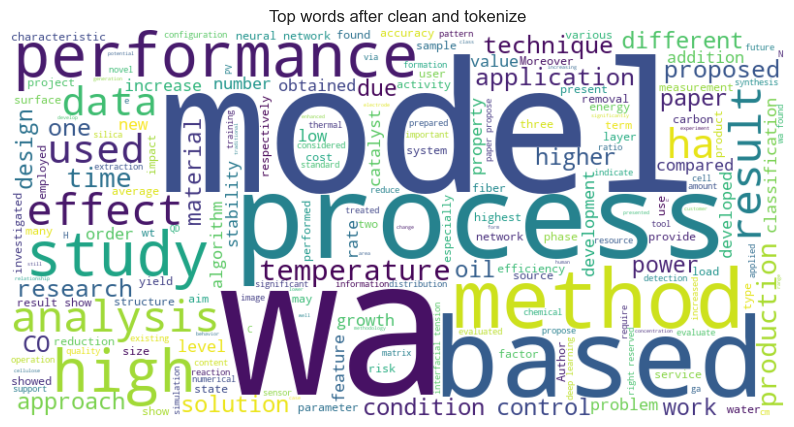

In [11]:
X_test = load_data(TEST_PATH, has_label=False)

In [12]:
X_test.shape

(151, 512)

In [13]:
submission_df = pd.DataFrame(columns= LABEL_LIST,
                             index= [f"{'0'*(3-len(str(k+1)))}{k+1}eval" for k in range(151)])

for label in LABEL_LIST:
    model = model_by_label[label]
    submission_df[label] = model.predict(X_test)

submission_df.index.name = "id"
submission_df

,CE,ENV,BME,PE,METAL,ME,EE,CPE,OPTIC,NANO,CHE,MATENG,AGRI,EDU,IE,SAFETY,MATH,MATSCI
id,,,,,,,,,,,,,,,,,,
001eval,0,0,0,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0
002eval,0,0,0,0,1,1,1,0,1,1,1,1,0,0,0,0,0,1
003eval,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1
004eval,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0
005eval,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
147eval,0,1,0,1,0,1,0,0,0,1,1,1,0,0,0,0,0,1
148eval,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
149eval,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1


In [14]:
submission_df.to_csv("submission.csv")

In [15]:
!kaggle competitions submit -c 2110446-data-science-2023-02 -f submission.csv -m "use embeded + Voting + Stemming + delete some word" 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


100%|██████████████████████████████████████| 6.57k/6.57k [00:02<00:00, 3.21kB/s]
Successfully submitted to 2110446 Data Science and Data Engineering Tools